# Sequential k-Means Clustering
Online k-means algorithm proposed [here](https://www.cs.princeton.edu/courses/archive/fall08/cos436/Duda/C/sk_means.htm)

In [ ]:
# Path to the CSV file containing the collected splats.
DATA_NAME = "collected_splats"

# Number of clusters.
CLUSTERS = 12

In [ ]:
from clustering_exploration.utils.data_handler import load_splats

splats = load_splats(DATA_NAME)

# Cluster Splats

In [ ]:
from numpy.random import default_rng

default_rng().shuffle(splats, axis=1)


In [7]:
from numpy import ndarray, zeros, where, abs, argmin, array, argsort


# For each pixel, [ K x [ mean, number, alpha_sum, transmittance, premultiplied_r, premultiplied_g, premultiplied_b ] ]
# After clustering, (1 - transmittance) gives final cluster alpha, and (pre_multiplied_color / alpha_sum) gives final cluster color

CLUSTER_MEAN = 0
SPLAT_COUNT = 1
ALPHA_SUM = 2
TRANSMITTANCE = 3
PREMULTIPLIED_COLOR = 4

def pixel_cluster(pixel_splats: ndarray) -> ndarray:
    # Output data.
    clusters = zeros((CLUSTERS, 7))

    for alpha, depth, *color in pixel_splats:
        # Skip zero alpha.
        if not alpha:
            continue
        # Skip zero depth.
        if not depth:
            continue

        # Compute cluster index.
        target_cluster_index = 0

        # Fill in initial guesses first.
        if (open_cluster_indices := where(clusters[:, CLUSTER_MEAN] == 0)) and len(open_cluster_indices):
            target_cluster_index = open_cluster_indices[0]
        else:
            target_cluster_index = argmin(abs(clusters[:, CLUSTER_MEAN] - depth))
        
        # Update cluster information.
        clusters[target_cluster_index, SPLAT_COUNT] += 1
        clusters[target_cluster_index, ALPHA_SUM] += alpha
        clusters[target_cluster_index, TRANSMITTANCE] *= 1 - alpha
        clusters[target_cluster_index, PREMULTIPLIED_COLOR:] += alpha * array(color)
        
        # Update cluster mean.
        current_mean = clusters[target_cluster_index, CLUSTER_MEAN]
        clusters[target_cluster_index, CLUSTER_MEAN] = current_mean + (depth - current_mean) / clusters[target_cluster_index, SPLAT_COUNT]
    
    # Compute final transmittance and color.
    for cluster_index, cluster in enumerate(clusters):
       clusters[cluster_index, TRANSMITTANCE] = 1 - cluster[TRANSMITTANCE]
       clusters[cluster_index, PREMULTIPLIED_COLOR:] /= cluster[ALPHA_SUM]
    
    # Sort clusters and return.
    return clusters[argsort(clusters[:, 0])][:, TRANSMITTANCE:]


In [9]:
from joblib import Parallel, delayed
from tqdm.auto import tqdm
clustered_splats = Parallel(n_jobs=-1)(delayed(pixel_cluster)(pixel_splat) for pixel_splat in tqdm(splats))

  0%|          | 0/1051648 [00:00<?, ?it/s]

# Compute Image From Clusters
Compute the final pixel color by alpha compositing the clusters.

  0%|          | 0/1051648 [00:00<?, ?it/s]

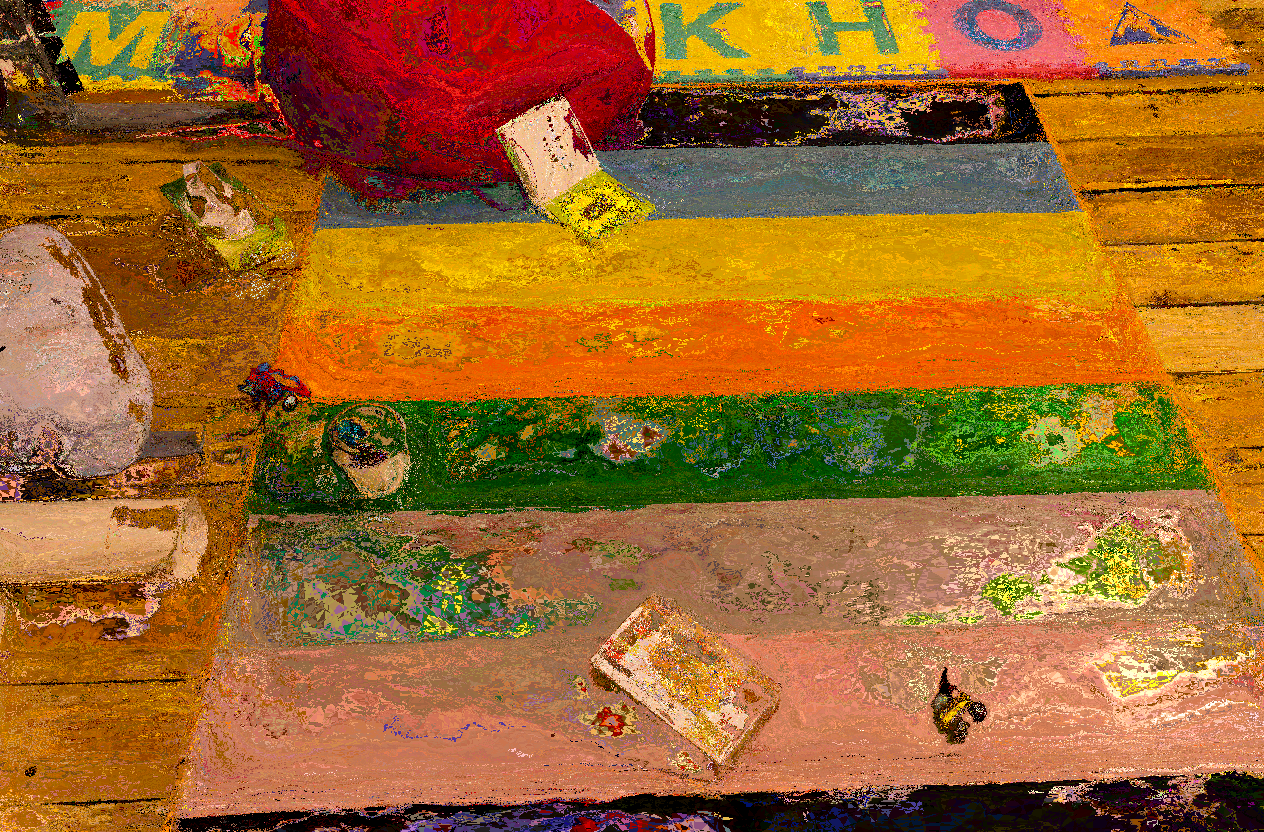

In [10]:
from clustering_exploration.utils.image_handler import compute_image_from_clusters

display(compute_image_from_clusters(clustered_splats, f"k_means_clustering_k_{CLUSTERS}"))